In [74]:
'''
FUNCTIONS
Many functions for fit to basic lorentzians and also for the MB parameters:
    E - our x values, usually v [mm/s]
    I - intensity (usually of lowest peak pair)
    B_hf - hyperfine splitting magnetic field
    IS - isomer shift
    gamma - width of peak
    QS - quadrapole splitting (for some functions)
    b - baseline, number of counts without absorbtion

DATA
Ferric floride (at short distance run for now), double sites of a magnetic and electric splits
Tourmaline - seems like a doublet, I think there should be QS and IS

Ammonium Iron Sulfate
    - run in liquid - flat
    - frozen run, to do: what do we expect it to look like?

'''

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import spinmob as s

In [75]:
'''
giving a fitter, returns an array of the fitted lorentzian1 parameters and errors in 2D array
arg: my_fitter = fit, x = integer value offset

'''
def getFits_lor(my_fitter, x):
    
    di = my_fitter.get_fit_results()
    results = [di[key] for key in di.keys()]
    
    center = [results[0+8*x], results[1+8*x]]
    dist = [results[2+8*x], results[3+8*x]]
    gamma = [results[4+8*x], results[5+8*x]]
    A = [results[6+8*x], results[7+8*x]]

    return [center, dist, gamma, A]

"""
Takes array of channels, and m, b of linear function
Returns array of velocities [mmsec]
"""
def chan_to_velo(channels, m, b):
    v = [m[0]*c + b[0] for c in channels]
    return v

def average(a, b, offset):
    
    center = (a[0] - b[0]) / 2.0 + offset[0]
    err = np.sqrt((np.sqrt((a[1])**2 + (b[1])**2)*0.5)**2+(offset[1])**2)
    
    return [center, err]

def lorentzian6const(E, center, dist, gamma, A, center_2, dist_2, gamma_2, A_2, center_3, dist_3, gamma_3, A_3, b):

    denom = (E-(center - dist))**2 + (gamma/2)**2
    denom_2 = (E-(center_2 - dist_2))**2 + (gamma_2/2)**2
    denom_3 = (E-(center_3 - dist_3))**2 + (gamma_3/2)**2
    denom_4 = (E-(center_3 + dist_3))**2 + (gamma_3/2)**2
    denom_5 = (E-(center_2 + dist_2))**2 + (gamma_2/2)**2
    denom_6 = (E-(center + dist))**2 + (gamma/2)**2
    
    return A*gamma**2/denom + A_2*gamma_2**2/denom_2 + A_3*gamma_3**2/denom_3 + A_3*gamma_3**2/denom_4 + A_2*gamma_2**2/denom_5 + A*gamma**2/denom_6 + b

def lorentzian4const(E, center, dist, gamma, A, center_2, dist_2, gamma_2, A_2, b):

    denom = (E-(center - dist))**2 + (gamma/2)**2
    denom_2 = (E-(center_2 - dist_2))**2 + (gamma_2/2)**2
    denom_5 = (E-(center_2 + dist_2))**2 + (gamma_2/2)**2
    denom_6 = (E-(center + dist))**2 + (gamma/2)**2
    
    return A*gamma**2/denom + A_2*gamma_2**2/denom_2 + A_2*gamma_2**2/denom_5 + A*gamma**2/denom_6 + b


def lorentzian6Magt(E, I, B_hf, IS, gamma, b):
    
    cal3 = 5.3115 #0.00055
    cal2 = 3.0639 #0.0006
    cal1 = 0.831 #0.0010

    denom = (E-( (-cal3/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_2 = (E-( (-cal2/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_3 = (E-( (-cal1/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_4 = (E-( (cal1/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_5 = (E-( (cal2/33.0)*B_hf + IS ))**2 + (gamma/2)**2
    denom_6 = (E-( (cal3/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    
    return 3*I*gamma**2/denom + 2*I*gamma**2/denom_2 + I*gamma**2/denom_3 + I*gamma**2/denom_4 + 2*I*gamma**2/denom_5 + 3*I*gamma**2/denom_6 + b
    
def lorentzian6MagtQS(E, I, B_hf, IS, gamma, QS, b):
    
    cal3 = 5.3115 #0.00055
    cal2 = 3.0639 #0.0006
    cal1 = 0.831 #0.0010

    denom = (E-( (-cal3/33.0)*B_hf + IS +QS) )**2 + (gamma/2)**2
    denom_2 = (E-( (-cal2/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_3 = (E-( (-cal1/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_4 = (E-( (cal1/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_5 = (E-( (cal2/33.0)*B_hf + IS -QS))**2 + (gamma/2)**2
    denom_6 = (E-( (cal3/33.0)*B_hf + IS +QS) )**2 + (gamma/2)**2
    
    return 3*I*gamma**2/denom + 2*I*gamma**2/denom_2 + I*gamma**2/denom_3 + I*gamma**2/denom_4 + 2*I*gamma**2/denom_5 + 3*I*gamma**2/denom_6 + b

#2 magnetic sites (so twice 6 peaks) with one baseline
def multiSiteLor6(E, I, B_hf, IS, gamma, QS, I_2, B_hf_2, IS_2, gamma_2, QS_2, b):
    
    Asites = lorentzian6MagtQS(E, I, B_hf, IS, gamma, QS, b)
    Bsites = lorentzian6MagtQS(E, I_2, B_hf_2, IS_2, gamma_2, QS_2, 0)
    
    return Asites + Bsites

#one magnetic site and one electric site with one baseline
def multiSiteMag_Ele(E, I, B_hf, IS, gamma, QS, I_2, center, dist, gamma_2, b):
    
    Asites = lorentzian6MagtQS(E, I, B_hf, IS, gamma, QS, b)
    Bsites = lorentzian2Const(E, center, dist, gamma_2, I_2, 0)
    
    return Asites + Bsites

def lorentzian6MagtQS_115(E, I, B_hf, IS, gamma, QS, b):
    
    cal3 = 5.3115 #0.00055
    cal2 = 3.0639 #0.0006
    cal1 = 0.831 #0.0010

    denom = (E-( (-cal3/33.0)*B_hf + IS +QS) )**2 + (gamma/2)**2
    denom_2 = (E-( (-cal2/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_3 = (E-( (-cal1/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_4 = (E-( (cal1/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_5 = (E-( (cal2/33.0)*B_hf + IS -QS))**2 + (gamma/2)**2
    denom_6 = (E-( (cal3/33.0)*B_hf + IS +QS) )**2 + (gamma/2)**2
    
    return I*gamma**2/denom + I*gamma**2/denom_2 + 5*I*gamma**2/denom_3 + 5*I*gamma**2/denom_4 + I*gamma**2/denom_5 + I*gamma**2/denom_6 + b

#2 lorentzians added together with one offset
def lorentzian2Const(E, center, dist, gamma, I, b):
    denom = (E- (center - dist) )**2 + (gamma/2)**2
    denom_2 = (E- (center + dist) )**2 + (gamma/2)**2

    return I*gamma**2/denom + I*gamma**2/denom_2 + b

#2 lorentzians added together with one offset
def lorentzian2QS(E, IS, QS, gamma, I, b):

    denom = (E- (IS - QS) )**2 + (gamma/2)**2
    denom_2 = (E- (IS + QS) )**2 + (gamma/2)**2

    return I*gamma**2/denom + I*gamma**2/denom_2 + b

#2 lorentzians added together with one offset
def lorentzian3Doublet(E, IS, QS, gamma, I, QS_2, I_2, IS_3, QS_3, I_3, b, c):

    Asite = lorentzian2QS(E, IS, QS, gamma, I, 0)
    Bsite = lorentzian2QS(E, IS, QS_2, gamma, I_2, 0)
    Csite = lorentzian2QS(E, IS_3, QS_3, gamma, I_3, 0)


    return Asite + Bsite + Csite + b+ c*E**2

In [76]:
# channel to velocity relation from calibration data
b = [11.000776381475806, 0.0011164921537570854] 
m = [-0.08527733629051013, 8.194955387410484e-06]


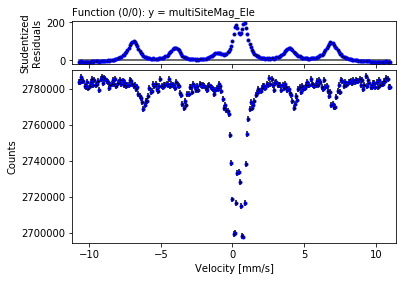

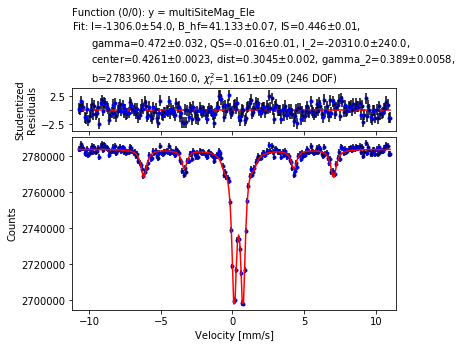


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Velocity [mm/s]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Counts']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 2607.028 +/- 0.09, 246.0 DOF)
  I          = -15000.0
  B_hf       = 43.0
  IS         = 0.0
  gamma      = 1.0
  QS         = 0.0
  I_2        = -80000.0
  center  

In [77]:
#Fit ferric floride (this run was at very short distance)

data = np.loadtxt(".//data//FFloride_Jan15_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
velocities = chan_to_velo(dataL[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

guess='I=-1.5e4, B_hf=43, IS=0, gamma=1.0, QS=0, I_2=-8e4, center=0.5, dist=0.3, gamma_2=0.5, b=2.8e6'    
my_fitter.set_functions(f=multiSiteMag_Ele, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# print(my_fitter.get_fit_results())
# resultsLS = getFits_lor(my_fitter, 0)


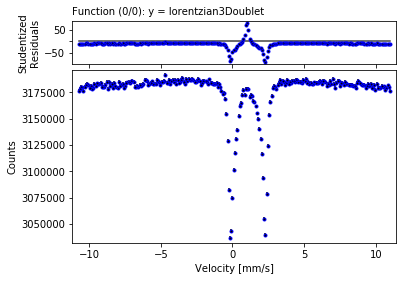

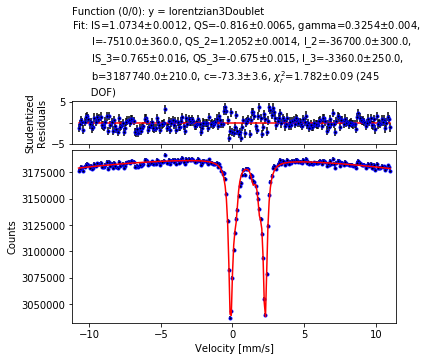


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Velocity [mm/s]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Counts']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 363.61 +/- 0.09, 245.0 DOF)
  IS         = 1.0
  QS         = 0.05
  gamma      = 0.2
  I          = -25000.0
  QS_2       = 1.0
  I_2        = -5000.0
  IS_3       

In [78]:
#Tourmaline

data = np.loadtxt(".//data//Tourmaline_Jan27_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
velocities = chan_to_velo(dataL[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

# def lorentzian3Doublet(E, IS, QS, gamma, I, QS_2, I_2, QS_3, I_3, b):

guess= 'IS=1.0, QS=0.05, gamma=0.2, I=-2.5e4, QS_2=1.0, I_2=-5e3, IS_3=0.2, QS_3=0.2, I_3=-5e3, b=3.2e6, c=-1e-3'
my_fitter.set_functions(f=lorentzian3Doublet, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# print(my_fitter.get_fit_results())
# resultsLS = getFits_lor(my_fitter, 0)


## Ammonium Iron Sulfate

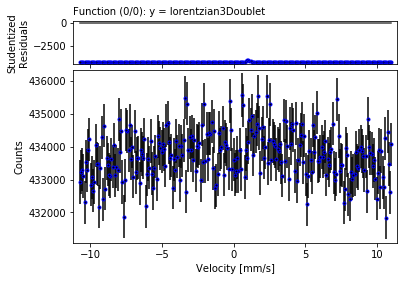

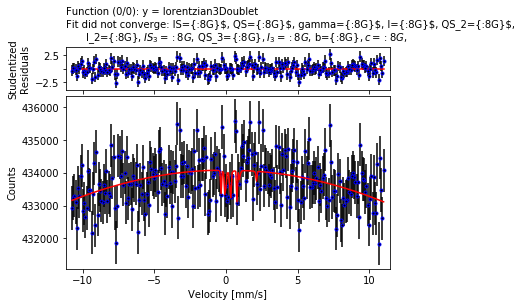


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Velocity [mm/s]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Counts']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 18381537.625 +/- 0.09, 245.0 DOF)
  IS         = 1.0
  QS         = 0.05
  gamma      = 0.2
  I          = -25000.0
  QS_2       = 1.0
  I_2        = -5000.0
  IS_3 

In [83]:
# Ammonium Iron Sulfate solution as Liquid
# this should just be basicly flat

data = np.loadtxt(".//data//AmmoniumIronSulfate_solutionLiquid_Jan28_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
velocities = chan_to_velo(dataL[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

guess= 'IS=1.0, QS=0.05, gamma=0.2, I=-2.5e4, QS_2=1.0, I_2=-5e3, IS_3=0.2, QS_3=0.2, I_3=-5e3, b=3.2e6, c=-1e-3'
my_fitter.set_functions(f=lorentzian3Doublet, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# print(my_fitter.get_fit_results())
# resultsLS = getFits_lor(my_fitter, 0)